## **SOBRE OS DADOS**


- **Qtd_Falhas**: Esta coluna representa a quantidade de vezes que uma máquina ou equipamento falhou ou precisou de manutenção corretiva.

- **Carga_media_Diaria**: Indica a carga operacional média que a máquina ou equipamento suporta em um dia típico. Pode ser um indicativo da intensidade de uso.

- **Esforco**: Mostra a pressão média sob a qual a máquina opera. Valores muito altos ou baixos podem indicar potenciais problemas ou necessidades de ajustes.

- **Nivel_Desgaste**: Representa o grau de desgaste dos componentes materiais da máquina, fornecendo uma ideia sobre a necessidade de substituição ou reparo de peças. Dados classificados através de inspeção visual pelo técnico da área

- **Score_Lubrificacao**: Reflete a adequação do nível de lubrificação da máquina, crucial para a manutenção da eficiência operacional e prevenção de desgastes prematuros.

- **Eficiência**: Uma medida geral da eficiência operacional da máquina, levando em conta fatores como consumo de energia, output e tempo de operação.

- **Score_Manutencao**: Uma pontuação derivada do histórico de manutenção da máquina, considerando a frequência, a gravidade das falhas passadas e as intervenções realizadas.

- **Idade**: A idade da máquina ou equipamento, um fator crucial que pode influenciar a frequência de manutenções e substituições de peças.

- **Necessidade_Manutencao**: Indica se uma máquina requer manutenção (preventiva ou corretiva) com base nos dados e condições operacionais atuais.

In [1]:
import pandas as pd
import numpy as np
from os import chdir
import matplotlib.pyplot as plt
import seaborn as sns

import warnings

sns.set()
warnings.filterwarnings('ignore')

tamanho_grafico = (15,8)

chdir(r"D:\EVALDO\CURSOS\MACHINE LEARNING\PREDITIVA IA\METERIAL DE APOIO\6. 3 - Data Science\4. Diagnóstico e Interpretação de Modelos\Parte 1 - Métricas de Performance em Classificação\Metricas_Classificacao_Diabetes")

In [2]:
dados = pd.read_csv('manutencao.csv')

### **Explorando os dados**
Aparentemente o DataFrame está completo e nenhum dado precisa ser transformado

In [3]:
dados.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Qtd_Falhas              768 non-null    int64  
 1   Carga_media_Diaria      768 non-null    int64  
 2   Esforco                 768 non-null    int64  
 3   Nivel_Desgaste          768 non-null    int64  
 4   Score_Lubrificacao      768 non-null    int64  
 5   Eficiência              768 non-null    float64
 6   Score_Manutencao        768 non-null    float64
 7   Idade                   768 non-null    int64  
 8   Necessidade_Manutencao  768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


---

## **Variável Alvo**

Vamos tentar entender um pouco mais sobre nosso alvo.

Saber por exemplo como é a distribuição pode nos dar um bom ponto de partida para nossa modelagem.

In [4]:
alvo = (dados['Necessidade_Manutencao'].value_counts()
.reset_index()
.rename(columns={'index':'Variavel', 'Necessidade_Manutencao':'Saida'}))

alvo['Percent'] = round(alvo['Saida'] / alvo['Saida'].sum() * 100,2)

In [5]:
alvo

,Variavel,Saida,Percent
0,0,500,65.1
1,1,268,34.9


Claramente temos uma base bastante desbalanceada

O que faz todo sentido, esperamos que a maioria das pessoas aprensente um nivel de diabetes saudável.

---

## **FEATURES DO DATASET**

Agora que já vimos o alvo, vamos ver como estão distribuidas as variáveis do Dataset. 

Por aqui, muitas vezes conseguimos identidicar situações que podem nos colocar em maus lençois se não tratadas corretamente. 

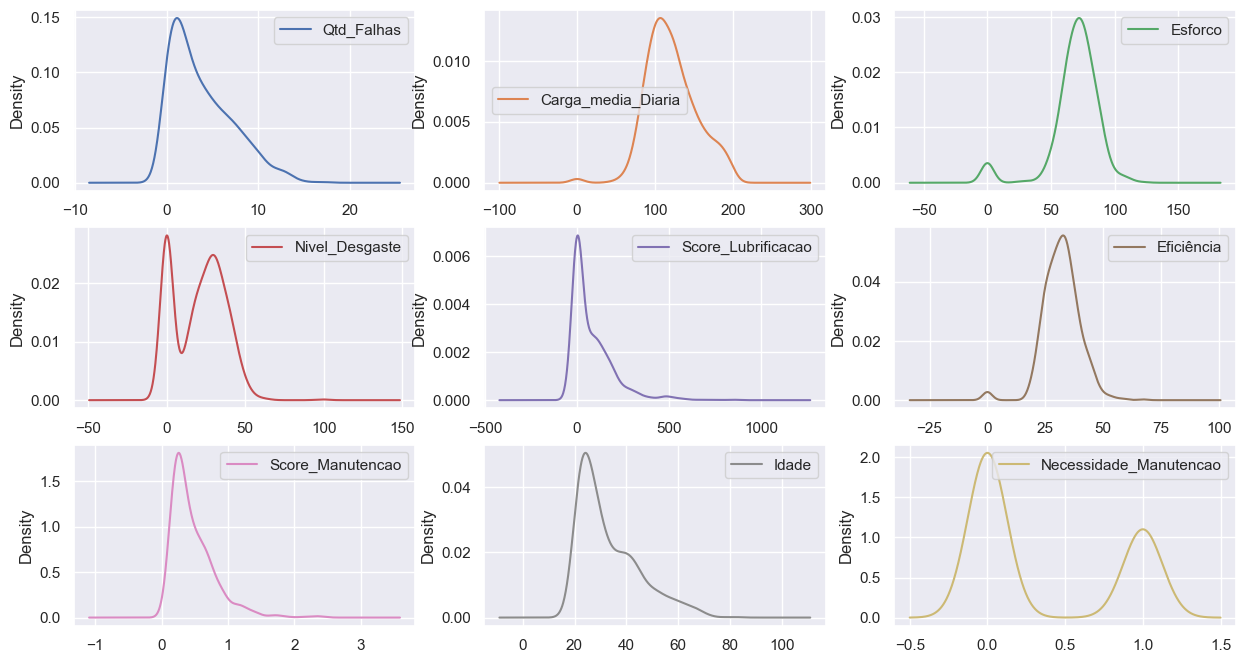

In [6]:
# Verificando a densidade dos dados
dados.plot(kind = 'density', subplots = True, layout = (3,3), sharex = False, figsize=tamanho_grafico)
plt.show()

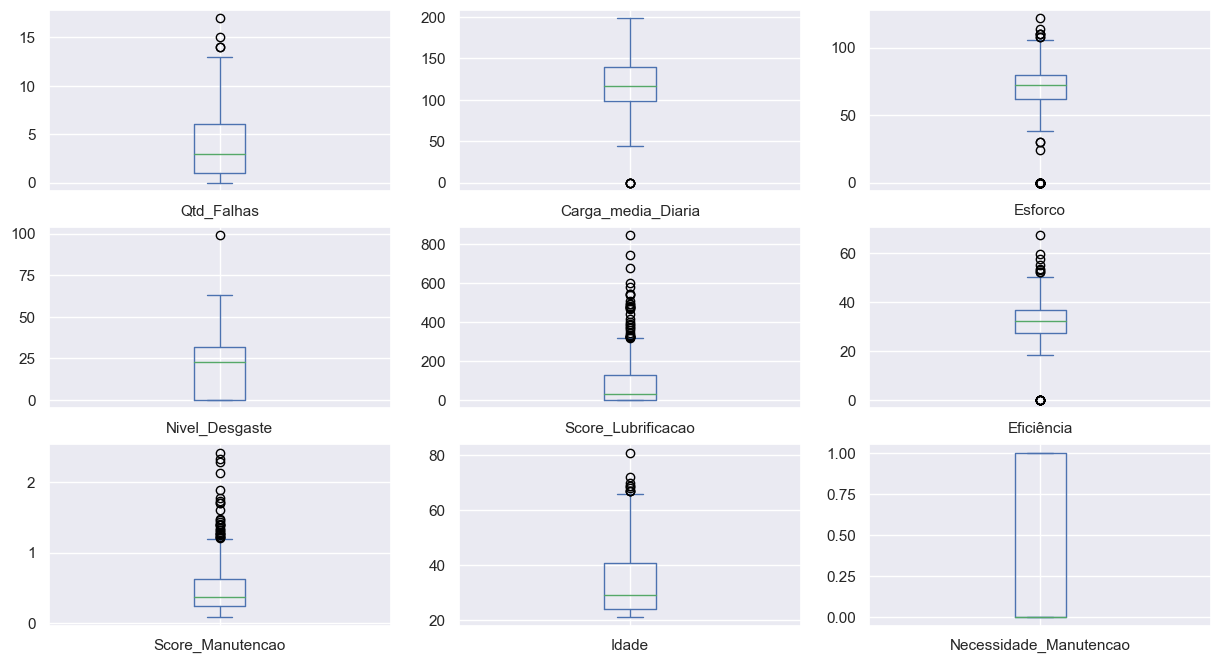

In [7]:
# Verificando possiveis dados fora de contexto
dados.plot(kind = 'box', subplots = True, layout = (3,3), sharex = False, sharey = False, figsize= tamanho_grafico)
plt.show()

Como alguns dados estão visilmente com valores estranho, vou dar uma olhada mais de perto com o Describe

In [10]:
dados.describe().T

,count,mean,std,min,25%,50%,75%,max
Qtd_Falhas,768.0,3.845052,3.369578,0.000,1.00000,3.0000,6.00000,17.00
Carga_media_Diaria,768.0,120.894531,31.972618,0.000,99.00000,117.0000,140.25000,199.00
Esforco,768.0,69.105469,19.355807,0.000,62.00000,72.0000,80.00000,122.00
Nivel_Desgaste,768.0,20.536458,15.952218,0.000,0.00000,23.0000,32.00000,99.00
Score_Lubrificacao,768.0,79.799479,115.244002,0.000,0.00000,30.5000,127.25000,846.00
Eficiência,768.0,31.992578,7.884160,0.000,27.30000,32.0000,36.60000,67.10
Score_Manutencao,768.0,0.471876,0.331329,0.078,0.24375,0.3725,0.62625,2.42
Idade,768.0,33.240885,11.760232,21.000,24.00000,29.0000,41.00000,81.00
Necessidade_Manutencao,768.0,0.348958,0.476951,0.000,0.00000,0.0000,1.00000,1.00


Podemos ver que alguns campos estão com valor minimo zerado, o que pode não fazer muito sentido. 

Neste caso é importante procurar as Áreas de Engenhaia de Manutenção ou PCM para entender os motivos disso. 

Para este estudo, farei filtros nas variáveis que julgo mais importantes: 

- **Carga_media_Diaria**. Pegarei dados maiores do que 0.
- **Esforco**. Pegarei dados maiores do que 0.
- **Score_Lubrificacao**. Não faz sentido o equipamento não ser lubrificado. 
- **Eficiência**. Pegarei dados maiores do que 0.



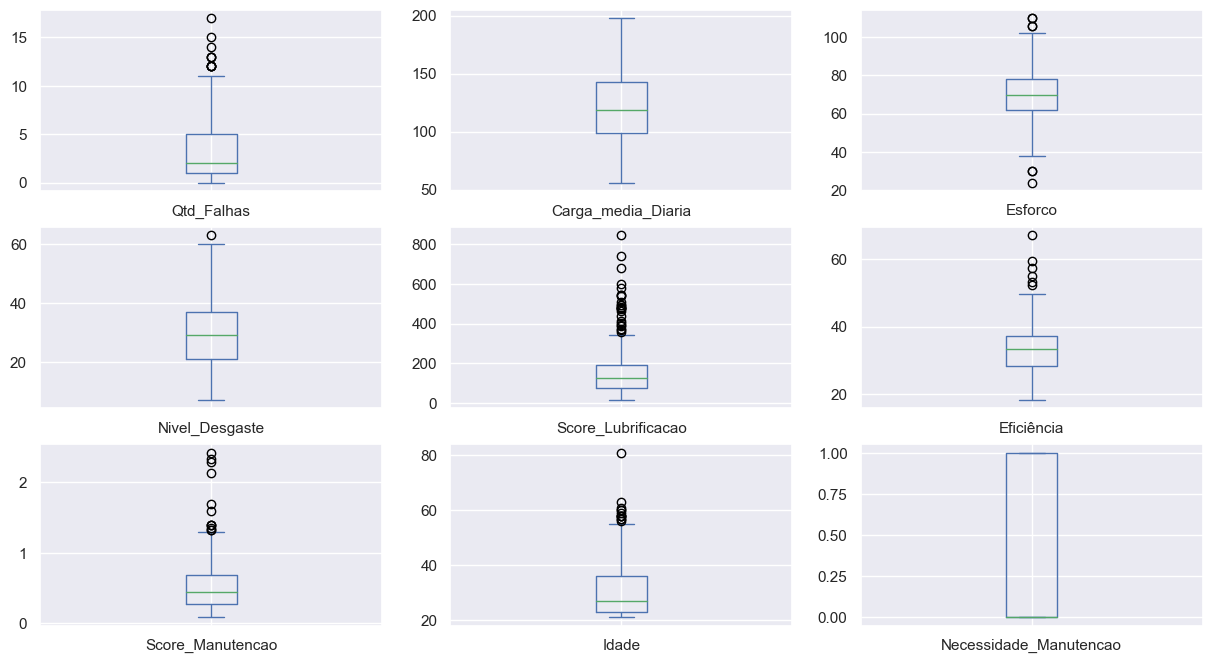

In [17]:
dados_filtrados = dados.query('Carga_media_Diaria > 0 and Esforco > 0 and Score_Lubrificacao > 0 and Eficiência > 0')
dados_filtrados.plot(kind = 'box', subplots = True, layout = (3,3), sharex = False, sharey = False, figsize= tamanho_grafico)
plt.show()

Como podemos ver, aparentemente já temos dados mais condizentes com a realidade. 

Aqui vale lembrar a imoprtancia que a área de dados tem dentro do ambiente de machine learning. É com eles que geralmente estes dados serão validados antes de colocarmos qualquer coisa em produção produção ou de treinar um modelo. 

---

### **Correlação das Variáveis com o Alvo**

Vamos dar uma olhada na distribuição dos dados em destacando quem tem e quem não tem Diabetes.

Veja o quanto a glicose aparentemente está relacionada com o Diabetes

Ela X qualquer outra variável do DataFrame sempre se destaca no que diz respeito a ter ou não o Diabetes. 


In [ ]:
sns.pairplot(dados_filtrados, hue='Outcome', corner=True)

Vamos ver quais as variáveis tem correlação como alvo

In [ ]:
(dados_filtrados.corr()['Outcome']
 .reset_index()
 .rename(columns={'index':'Variável', 'Outcome':'Correlacao'})
 .sort_values(by='Correlacao', ascending=False))[1:]

Ficou clare que Glicose, Idade, Insulina e Massa corporal, tem sim uma forte correlação com o Diabetes.

Vale a pena investirmos tempo em uma atividade física que por si só já controla os dois principais fatores que podem contribuir para a doença.

### **Correlação das Variáveis com elas mesmas**

In [ ]:
plt.title('Correlação entre as Variáveis', fontsize = 20)
sns.heatmap(dados_filtrados.corr(), fmt='.2f', annot=True)

---

## **Modelagem**

Sobre o que vamos modelar:

1) Temos que ter em mente que nossa base é desbalanceada, logo teremos que ter uma boa interpretação do modelo
2) Por conta do desbalanceamento da base, basta o modelo "chutar" que as pessoas não tem Diabetes. Isso já dá a ele 65% de acerto. Precisamos mais do que isso.
3) A métrica aqui é a ROC Score, jutamente por conta do desbalanceamento
4) Por conta do desbalanceamento terei que ter muito cuidado na validação do modelo. Validação cruzada aqui não é uma opção
5) É muito importante que nosso modelo acerte o maior numero de pessoas sem Diabestes possivel, porque uma vez que ele informe que uma pessoa tem diabetes, o médico pode solicitar um exame adicional. Já quando diz que a pessoa não tem, isso pode ocasionar um problema maior, porque pode induzir a pessoa a se expor a situações nocivas para sua saude. Falo aqui de alimentação, exercicios....

In [ ]:

from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import train_test_split

from sklearn.metrics import roc_auc_score
from sklearn.metrics import auc
from sklearn.metrics import roc_curve
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.model_selection import cross_val_score


In [ ]:
x = dados_filtrados.drop('Outcome', axis=1)
y= dados_filtrados['Outcome']

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=.30, stratify= y)

In [ ]:
y_test.size

In [ ]:
lg = LogisticRegression(fit_intercept=True, max_iter= 100)
lg.fit(x_train, y_train)


pred_prob = lg.predict_proba(x_test)[:,1]
threshold = np.percentile(pred_prob, 35)
previsao = np.where(pred_prob >= threshold, 1, 0) 


print(f'Roc Score {roc_auc_score(y_test, previsao) * 100 :.2f} %')
print(classification_report(y_test, previsao))
plt.title('Matrix de Confusão - Logistic Regression')
sns.heatmap(confusion_matrix(y_test, previsao), annot=True, fmt=".2f")

# Curva ROC
y_scores = lg.predict_proba(x_test)

fpr, tpr, thresholds = roc_curve(y_test, pred_prob)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taxa de Falsos Postivos')
plt.ylabel('Taxa de Verdadeiros Positivos')
plt.title('Comportamento da Curva')
plt.legend(loc="lower right")
plt.show()

## **Sobre os Resultados do Modelo**

1) Veja que do total de pessoas com Diabetes, nosso modelo avaliou corretamente cerca de 49%. 
2) Já em relação as pessoas que não tinham Diabetes, ele acertou cerca de 97%

---

#### **VALIDAÇÃO CRUZADA ESTRATIFICADA**

Conforme comentei antes, a validação cruzada neste conjunto não é uma opção. E aqui temos que ter mais um cuidado, os dados estão desbalanceados e pode acontecer de passarmos por um split muito favorável a nosso modelo ou muito desfavorável. Por isso, vou utilizar o a validação cruzada Estratificada. 

Assim, vou manter meus dados mais bem distribuidos para o modelo.

In [ ]:
from sklearn.model_selection import StratifiedKFold


In [ ]:
particoes = StratifiedKFold(n_splits = 10, shuffle = True, random_state = 42) 

In [ ]:
x = dados_filtrados.drop('Outcome', axis=1)
y= dados_filtrados['Outcome']

In [ ]:
roc_train = []
roc_test = []
target_train = []
target_test = []


for train_index, test_index in particoes.split(x,y): # Aqui colocamos o parâmetro y para que o particionador saiba calcular as proporções
    
    # Separa a base    
    X_train, X_test = x.iloc[train_index], x.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    

    target_train.append(np.where(y_train ==  1,1,0).mean())
    target_test.append(np.where(y_test == 1,1,0).mean())
    
    
    modelo = LogisticRegression(solver='newton-cg', C= 0.0028429269880748463)
    modelo.fit(X_train, y_train)
    
    # AUC de Treino
    prob_train = modelo.predict_proba(X_train)[:,1]
    threshold_train = np.percentile(prob_train, 35)
    previsao_train = np.where(prob_train >= threshold_train, 1, 0) 
    roc_train.append(roc_auc_score(y_train, previsao_train))
    
    # AUC de Teste
    prob_test = modelo.predict_proba(X_test)[:,1]
    threshold_test = np.percentile(prob_test, 35)
    previsao_test = np.where(prob_train >= threshold, 1, 0) 
    roc_test.append(roc_auc_score(y_train, previsao_test))
    
    
resultado = pd.DataFrame({"Target de Treino":target_train,"Target de Teste":target_test,"AUC de Treino":roc_train, "AUC de Teste":roc_test})
resultado['Diferenca']= abs(resultado['AUC de Treino'] - resultado['AUC de Teste'])
resultado.sort_values(by='Diferenca')

# **Resultado Geral**

In [ ]:
resultado.describe().loc[['mean','std']][['AUC de Treino','AUC de Teste']]

## **Otimizando os Parametros do Modelo**

In [ ]:
import optuna

def objective(trial):
    
    # Desativando o Verbose do Optuna 
    optuna.logging.set_verbosity(optuna.logging.WARNING)
    
    # Definindo os hiperparâmetros a serem otimizados pelo Optuna
    solver = trial.suggest_categorical('solver', ['newton-cg', 'lbfgs', 'liblinear'])
    C = trial.suggest_loguniform('C', 1e-4, 1e4)
    
    # Criando o modelo com os hiperparâmetros sugeridos
    model = LogisticRegression(solver=solver, C=C)

    # Avaliação com validação cruzada
    score = cross_val_score(model, x, y, n_jobs=-1, cv=3)
    accuracy = np.mean(score)

    return accuracy

# Criando um estudo Optuna e buscando os melhores hiperparâmetros
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

# Melhores hiperparâmetros encontrados
best_params = study.best_params
print('Melhores hiperparâmetros:', best_params)


## **Aplicando Parametros do OPTUNA no Modelo**

In [ ]:
roc_train = []
roc_test = []
target_train = []
target_test = []
modelo = LogisticRegression(solver='newton-cg', C= 0.0028429269880748463)

for train_index, test_index in particoes.split(x,y): # Aqui colocamos o parâmetro y para que o particionador saiba calcular as proporções
    
    # Separa a base    
    X_train, X_test = x.iloc[train_index], x.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    # Calculando Percentual de 0 e 1
    target_train.append(np.where(y_train ==  1,1,0).mean())
    target_test.append(np.where(y_test == 1,1,0).mean())
    
    # Colocando parametros para verificar se o modelo melhorou
   
    modelo.fit(X_train, y_train)
    
    # AUC de Treino
    prob_train = modelo.predict_proba(X_train)[:,1]
    threshold_train = np.percentile(prob_train, 35)
    previsao_train = np.where(prob_train >= threshold_train, 1, 0) 
    roc_train.append(roc_auc_score(y_train, previsao_train))
    
    # AUC de Teste
    prob_test = modelo.predict_proba(X_test)[:,1]
    threshold_test = np.percentile(prob_test, 35)
    previsao_test = np.where(prob_train >= threshold, 1, 0) 
    roc_test.append(roc_auc_score(y_train, previsao_test))
    
    
resultado = pd.DataFrame({"Target de Treino":target_train,"Target de Teste":target_test,"AUC de Treino":roc_train, "AUC de Teste":roc_test})
resultado['Diferenca']= abs(resultado['AUC de Treino'] - resultado['AUC de Teste'])
resultado.sort_values(by='Diferenca')

In [ ]:
resultado.describe().loc[['mean','std']][['AUC de Treino','AUC de Teste']]

## **PESO DAS FEATURES NO MODELO**

In [ ]:
pd.DataFrame({'Item':x.columns, 'Coeficientes': modelo.coef_.ravel(), 'Odds':np.exp(modelo.coef_).ravel()}).sort_values(by='Odds', ascending=False)

In [ ]:

new_column_names_pt = {
    'Pregnancies': 'Qtd_Falhas',
    'Glucose': 'Carga_media_Diaria',
    'BloodPressure': 'Esforco',
    'SkinThickness': 'Nivel_Desgaste',
    'Insulin': 'Score_Lubrificacao',
    'BMI': 'Eficiência',
    'DiabetesPedigreeFunction': 'Score_Manutencao',
    'Age': 'Idade',
    'Outcome': 'Necessidade_Manutencao'
}


In [ ]:
manute = dados.rename(columns=new_column_names_pt)

In [ ]:
manute.to_csv('manutencao.csv', index= False)